 88582 unique tokens found
shape of data tensor: (25000, 100)
shape of label tensor: (25000, 100)
found 400000 word vectors.
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_22 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
125/125 [==============================] - 2s 12ms/step - loss: 1.0330 - acc: 0.5329 - val_loss: 0.6549 -

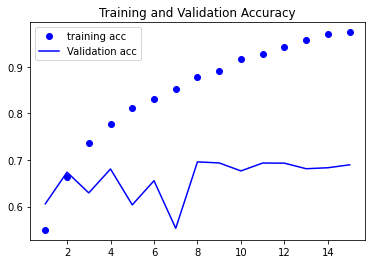

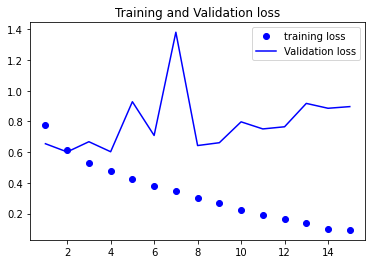

In [24]:
#Using GloVe Embeddings
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#Processing the labels of the raw IMDB data
imdb_dir = '/content/aclImdb'
train_dir=os.path.join(imdb_dir,'train')

labels = []
texts = []

for label_type in ['neg','pos']:
  dir_name = os.path.join(train_dir,label_type)
  for fname in os.listdir(dir_name):
      if fname[-4:] == '.txt':
        f = open(os.path.join(dir_name,fname))
        texts.append(f.read())
        f.close()
        if label_type == 'neg' :
          labels.append(0)
        else:
          labels.append(1)

#Tokenizing the text of the raw IMDB data
maxlen = 100
training_samples = 8000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print(' %s unique tokens found' %len(word_index))

data = pad_sequences(sequences,maxlen=maxlen)

labels = np.asarray(labels)
print('shape of data tensor:', data.shape)
print('shape of label tensor:', data.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

#Parsing the GloVe word-embeddings file
glove_dir = '/content/drive/MyDrive/Dataset/Glove/glovee'



embeddings_index = {}
f =open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np. asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('found %s word vectors.' %len(embeddings_index))

#Preparing the GloVe word-embeddings matrix
embeddings_dim = 100

embedding_matrix = np.zeros((max_words,embeddings_dim))
for word,i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

#Defining a Model 

model = Sequential()
model.add(Embedding(max_words,embeddings_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.summary()

#Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#Training and evaluation
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train,y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

#Plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label='training acc') 
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
#plots graph for training and validation loss
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()